# Pauli noise model for QECC encoding circuit


In [1]:
import numpy as np
# from qiskit_experiments.library import StandardRB, InterleavedRB
# from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
# import qiskit.circuit.library as circuits
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

# For simulation
from qiskit_aer import AerSimulator, Aer
# from qiskit.providers.fake_provider import FakePerth

# backend = AerSimulator.from_backend(FakePerth())

## 3 qubit
First, we consider a 3 qubit case and m = 1.

In [2]:
# m = [0,1,2,3,4,6,8]
# list_m = np.array([1,2,3,4,6,8])
# depths = [d for d in m for _ in range(num_sequences_per_depth)]
m = 1
num_samples = 10
qr_num_qubits = 2
anc_num_qubits = 1
num_qubits = 3
classcal_bit = 1
shots = 1000
seed = 1010

We use the randomized benchmarking code to help us to create a circuit.

In [3]:
from qiskit_experiments.library.randomized_benchmarking import CliffordUtils

In [4]:
CliffordUtils.random_clifford_circuits(1,num_qubits)[0].qregs

C:\Users\86178\AppData\Local\Temp\ipykernel_18268\2973171133.py:1: DeprecationWarning: The method 'random_clifford_circuits' of 'CliffordUtils' class has been deprecated and will be removed after Qiskit Experiments 0.6. 
  CliffordUtils.random_clifford_circuits(1,num_qubits)[0].qregs


[QuantumRegister(1, 'q')]

In [5]:
from numpy.random import Generator, default_rng
# from qiskit.quantum_info import Clifford, random_clifford
from typing import Optional, Union, Tuple, Sequence

def add_random_one_layer_clifford_gate(circ: QuantumCircuit, num_qubits: int, size: int, rng: Optional[Union[int, Generator]] = None):
    if rng is None:
        rng = default_rng()
    elif isinstance(rng, int):
        rng = default_rng(rng)
    # have some speed than random_clifford.
    samples = rng.integers(CliffordUtils.NUM_CLIFFORD_1_QUBIT, size=size)
    
    list_circuit = [CliffordUtils.clifford_1_qubit(i).to_instruction() for i in samples]
    
    for i in range(num_qubits):
        circ.append(list_circuit[i], [i])
    circ.barrier()
    return circ

start Clifford gate

In [6]:
qr = QuantumRegister(qr_num_qubits, 'q')
anc = QuantumRegister(anc_num_qubits, 'ancilla')
cr = ClassicalRegister(classcal_bit, 'c')
qc = QuantumCircuit(qr, anc, cr)

# circ = QuantumCircuit(num_qubits)
qc = add_random_one_layer_clifford_gate(qc, num_qubits, num_qubits)
qc.draw()

┌──────────────────────────────────────────────────────┐ ░ 
    q_0: ┤ Clifford: Stabilizer = ['+Y'], Destabilizer = ['+X'] ├─░─
         ├──────────────────────────────────────────────────────┤ ░ 
    q_1: ┤ Clifford: Stabilizer = ['+Y'], Destabilizer = ['+Z'] ├─░─
         ├──────────────────────────────────────────────────────┤ ░ 
ancilla: ┤ Clifford: Stabilizer = ['-X'], Destabilizer = ['+Z'] ├─░─
         └──────────────────────────────────────────────────────┘ ░ 
    c: 1/═══════════════════════════════════════════════════════════

ramdom pauli gate

In [7]:
# random_pauli_list()
from qiskit.quantum_info import  random_pauli_list

def add_random_one_layer_pauli_gate(circ: QuantumCircuit, num_qubits: int, size: int, rng: Optional[Union[int, Generator]] = None):
    
    if rng is None:
        rng = default_rng()
    elif isinstance(rng, int):
        rng = default_rng(rng)
    # have some speed than random_clifford.
    
    pauli_list = random_pauli_list(1, size, rng)
    list_circuit = [i.to_instruction() for i in pauli_list]
    
    for i in range(num_qubits):
        circ.append(list_circuit[i], [i])
    circ.barrier()
    return circ

In [8]:
qr = QuantumRegister(qr_num_qubits, 'q')
anc = QuantumRegister(anc_num_qubits, 'ancilla')
cr = ClassicalRegister(classcal_bit, 'c')
qc = QuantumCircuit(qr, anc, cr)

qc = add_random_one_layer_pauli_gate(qc, num_qubits, num_qubits)
qc.draw()

┌────┐ ░ 
    q_0: ─┤ -Y ├─░─
          ├────┤ ░ 
    q_1: ─┤ -X ├─░─
         ┌┴────┤ ░ 
ancilla: ┤ -iZ ├─░─
         └─────┘ ░ 
    c: 1/══════════

ancilla preparation circuit, firstly, we consider the only 3  bit flip repetition code.

In [9]:
def three_qubit_bit_flip_encoding(circ: QuantumCircuit):
    circ.cx(0, 2)
    circ.cx(1, 2)
    circ.barrier()
    return circ
qr = QuantumRegister(qr_num_qubits, 'q')
anc = QuantumRegister(anc_num_qubits, 'ancilla')
cr = ClassicalRegister(classcal_bit, 'c')
qc = QuantumCircuit(qr, anc, cr)

qc = three_qubit_bit_flip_encoding(qc)
qc = three_qubit_bit_flip_encoding(qc)
qc.draw()


░            ░ 
    q_0: ──■────────░───■────────░─
           │        ░   │        ░ 
    q_1: ──┼────■───░───┼────■───░─
         ┌─┴─┐┌─┴─┐ ░ ┌─┴─┐┌─┴─┐ ░ 
ancilla: ┤ X ├┤ X ├─░─┤ X ├┤ X ├─░─
         └───┘└───┘ ░ └───┘└───┘ ░ 
    c: 1/══════════════════════════

tow round is indentity matrix.

In [10]:
sim = AerSimulator(method="stabilizer")

qr = QuantumRegister(qr_num_qubits, 'q')
anc = QuantumRegister(anc_num_qubits, 'ancilla')
# cr = ClassicalRegister(classcal_bit, 'c')
qc = QuantumCircuit(qr, anc)

qc = three_qubit_bit_flip_encoding(qc)
qc = three_qubit_bit_flip_encoding(qc)
qc.measure_all()
print(qc.draw())
print(sim.run(qc).result().get_counts())


                    ░            ░  ░ ┌─┐      
    q_0: ──■────────░───■────────░──░─┤M├──────
           │        ░   │        ░  ░ └╥┘┌─┐   
    q_1: ──┼────■───░───┼────■───░──░──╫─┤M├───
         ┌─┴─┐┌─┴─┐ ░ ┌─┴─┐┌─┴─┐ ░  ░  ║ └╥┘┌─┐
ancilla: ┤ X ├┤ X ├─░─┤ X ├┤ X ├─░──░──╫──╫─┤M├
         └───┘└───┘ ░ └───┘└───┘ ░  ░  ║  ║ └╥┘
 meas: 3/══════════════════════════════╩══╩══╩═
                                       0  1  2 
{'000': 1024}


Randomise Gates:
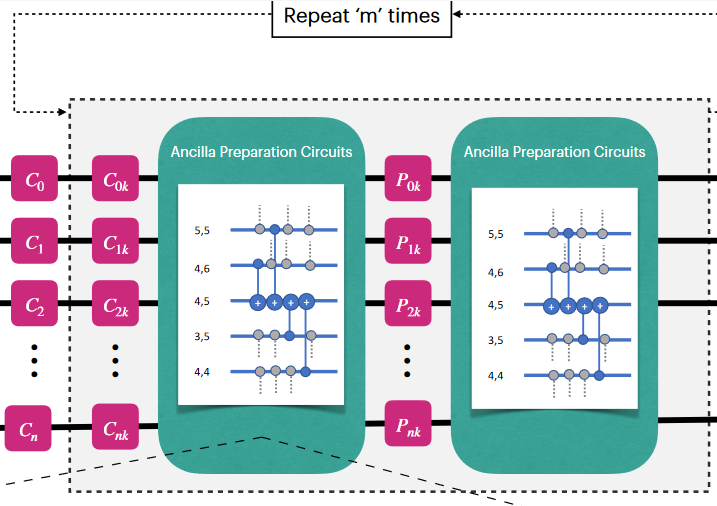

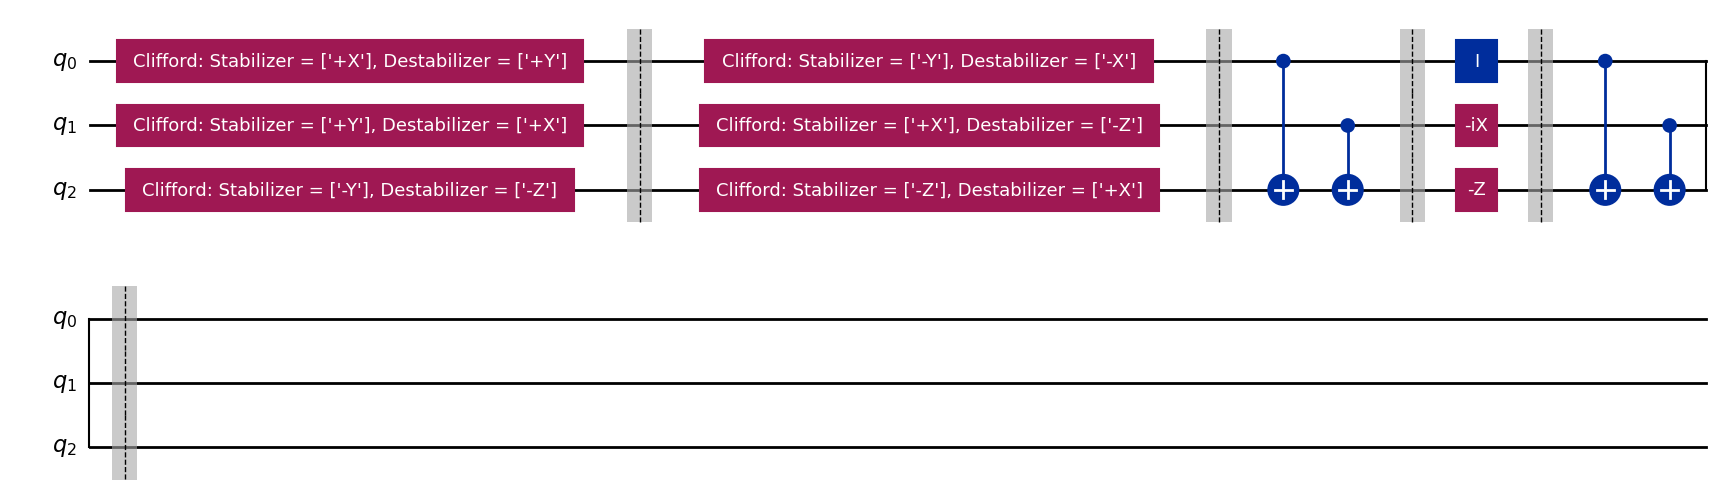

In [11]:
from qiskit_experiments.library.randomized_benchmarking import CliffordUtils

qr = QuantumRegister(num_qubits, 'q')
# anc = QuantumRegister(anc_num_qubits, 'ancilla') anc
# cr = ClassicalRegister(num_qubits, 'c'), cr
qc = QuantumCircuit(qr)

def random_benchmarking_circuit(circ: QuantumCircuit, num_qubits: int, rep_m: int):
    # start clifford
    circ = add_random_one_layer_clifford_gate(qc,num_qubits, num_qubits)

    for _ in range(rep_m):
        # random clifford gate on each qubit
        circ = add_random_one_layer_clifford_gate(qc,num_qubits, num_qubits)
        # encoding function
        circ = three_qubit_bit_flip_encoding(qc)
        # random pauli gate on each qubit
        circ = add_random_one_layer_pauli_gate(qc,num_qubits, num_qubits)
        # second round encoding function 
        circ = three_qubit_bit_flip_encoding(qc)
    
    return circ

qc = random_benchmarking_circuit(qc, num_qubits = num_qubits, rep_m = m)
qc.draw(output="mpl", style="iqp")

how to Apply inverse?

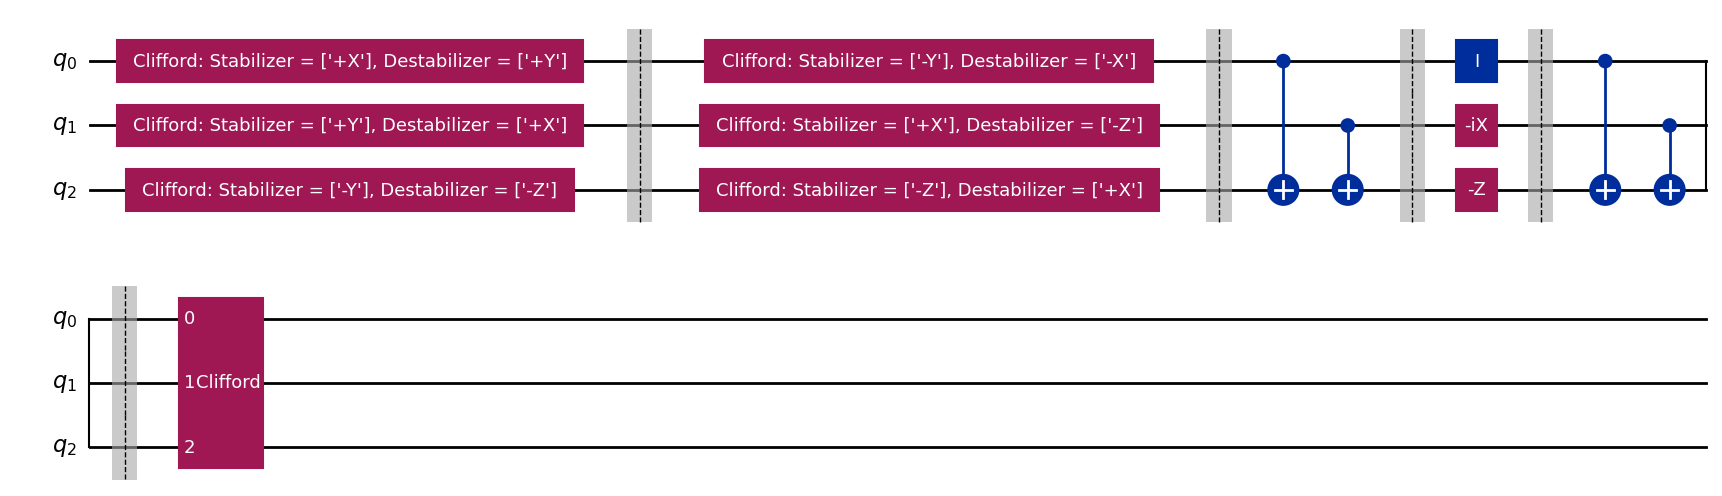

In [12]:
from qiskit.quantum_info import Clifford
inverse_qc = Clifford(qc.inverse())

qc = qc.compose(inverse_qc)
qc.draw(output="mpl", style="iqp")

In [13]:
from qiskit import transpile
transpile_qc = transpile(qc, sim)

In [14]:
transpile_qc.draw()

global phase: 3π/2
     ┌───┐┌───┐      ░ ┌───┐ ┌───┐       ░            ░ ┌───┐ ░            ░ »
q_0: ┤ Y ├┤ H ├──────░─┤ X ├─┤ H ├───────░───■────────░─┤ I ├─░───■────────░─»
     ├───┤└───┘      ░ ├───┤┌┴───┴┐┌───┐ ░   │        ░ ├───┤ ░   │        ░ »
q_1: ┤ Z ├───────────░─┤ Y ├┤ Sdg ├┤ H ├─░───┼────■───░─┤ Z ├─░───┼────■───░─»
     ├───┤┌───┐┌───┐ ░ ├───┤└┬───┬┘└───┘ ░ ┌─┴─┐┌─┴─┐ ░ ├───┤ ░ ┌─┴─┐┌─┴─┐ ░ »
q_2: ┤ S ├┤ H ├┤ S ├─░─┤ X ├─┤ H ├───────░─┤ X ├┤ X ├─░─┤ I ├─░─┤ X ├┤ X ├─░─»
     └───┘└───┘└───┘ ░ └───┘ └───┘       ░ └───┘└───┘ ░ └───┘ ░ └───┘└───┘ ░ »
«      ┌───┐           
«q_0: ─┤ X ├───────────
«      ├───┤ ┌───┐┌───┐
«q_1: ─┤ X ├─┤ H ├┤ S ├
«     ┌┴───┴┐├───┤└───┘
«q_2: ┤ Sdg ├┤ H ├─────
«     └─────┘└───┘

In [15]:
# qc = decomposed_circuit.(inverse_qc)
transpile_qc.measure_all()
sim.run(transpile_qc).result().get_counts()

{'000': 1024}

尝试实现一个整体的函数。

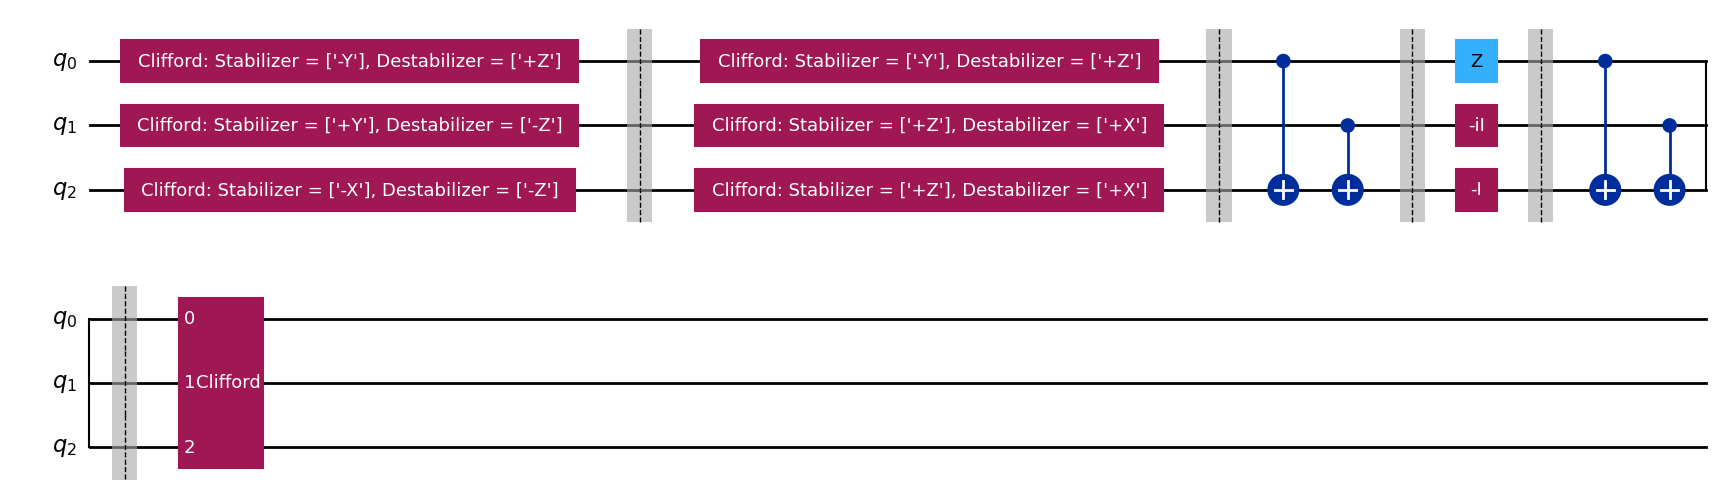

In [16]:
from qiskit.quantum_info import Clifford
from qiskit import transpile


qr = QuantumRegister(num_qubits, 'q')
# anc = QuantumRegister(anc_num_qubits, 'ancilla') anc
# cr = ClassicalRegister(num_qubits, 'c'), cr
qc = QuantumCircuit(qr)

def random_benchmarking(circ: QuantumCircuit, num_qubits: int, rep_m: int, sim):
    # start clifford
    circ = add_random_one_layer_clifford_gate(circ,num_qubits, num_qubits)

    for _ in range(rep_m):
        # random clifford gate on each qubit
        circ = add_random_one_layer_clifford_gate(circ,num_qubits, num_qubits)
        # encoding function
        circ = three_qubit_bit_flip_encoding(circ)
        # random pauli gate on each qubit
        circ = add_random_one_layer_pauli_gate(qc,num_qubits, num_qubits)
        # second round encoding function 
        circ = three_qubit_bit_flip_encoding(circ)
    # Apply inverse
    inverse_qc = Clifford(circ.inverse())
    
    # compose circuit
    circ = circ.compose(inverse_qc)
    # print("inverse_qc", inverse_qc)
    
    # transpile
    transpile_qc = transpile(circ, sim)
    # print(transpile_qc)
    # measure
    transpile_qc.measure_all()
    
    # run the circuit
    # print(transpile_qc)
    result = sim.run(transpile_qc).result()
    
    # get the Probability distributions
    counts = result.get_counts()
    return circ, result, counts

sim = AerSimulator(method="stabilizer")
qc, result, counts= random_benchmarking(qc, num_qubits = num_qubits, rep_m = m, sim = sim)
qc.draw(output="mpl", style="iqp")

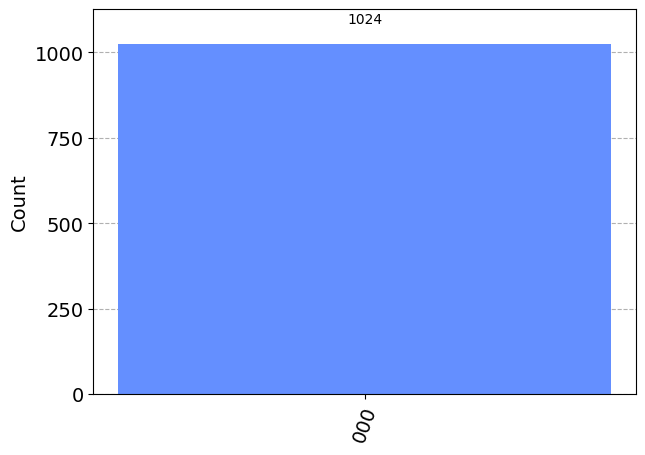

In [17]:
from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

000 1024


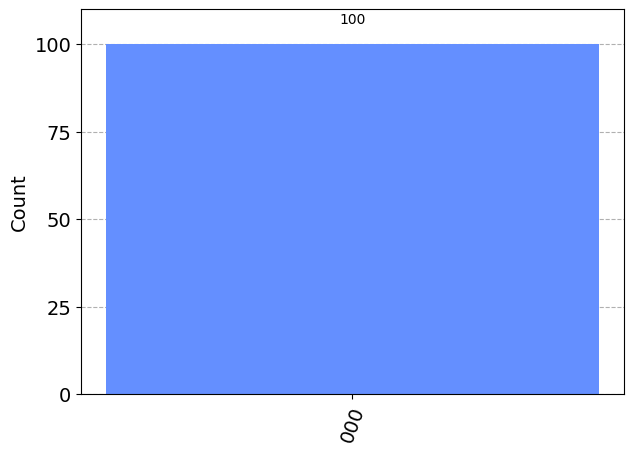

In [18]:
from qiskit.result import Counts

for key, value in counts.items():
    print(key, value)
plot_histogram(Counts({"000":100}))

## different m 

noise simulator

In [19]:
# For simulation
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

backend = AerSimulator.from_backend(FakePerth())

In [20]:
# #lengths 
# list_m = np.arange(1, 6, 1)
# num_samples = 10
# seed = 1010
# qubits = [0]
# print(f"qubits is {qubits},\nlist_m is {list_m},\nnum_samples is {num_samples},\nseed is {seed}")

# # Run an RB experiment on qubit 0

# # exp1.set_experiment_options()

# expdata1 = exp1.run(backend, seed=seed).block_for_results()


# # expdata1.experiment.analysis.set_options(gate_error_ratio = {'x': 0.0, 'rz': 0.0, 'sx': 1.0})
# results1 = expdata1.analysis_results()
# # View result data
# print("Gate error ratio: %s" % expdata1.experiment.analysis.options.gate_error_ratio)
# display(expdata1.figure(0))
# for i in range(len(results1)):
#     print(f"-------------------{i}-------------")
#     print(results1[i])

## Noise model

In [21]:
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

In [22]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


我们考虑reset、measurement可能出现错误，同时单比特门也可能出现X、Y、Z错误，同时双比特门也可能出现类似的错误的tensor，不过出现概率为单比特门的两倍。

In [23]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1

p_gate_x = 0.05
p_gate_y = 0.02
p_gate_z = 0.03

# p_two_gate = 0.1
# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])

error_gate2 = pauli_error([('X',p_gate_x*2), ('Y',p_gate_y*2), ('Z',p_gate_z*2), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z)*2)])
error_two_gate = error_gate1.tensor(error_gate1)

# Add errors to noise model
pauli_noise_model= NoiseModel()
pauli_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
pauli_noise_model.add_all_qubit_quantum_error(error_meas, "measure")
pauli_noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
pauli_noise_model.add_all_qubit_quantum_error(error_two_gate, ["cx"])

print(pauli_noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'measure', 'u3', 'u1', 'u2', 'reset']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [24]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model = pauli_noise_model, method="stabilizer")

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)
print(circ_tnoise)
# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# # Plot noisy output
# plot_histogram(counts_bit_flip)

global phase: π/4
        ┌─────────┐┌────┐┌─────────┐                ░ ┌─┐         
   q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├──■─────────────░─┤M├─────────
        └─────────┘└────┘└─────────┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ────────────────────────────┤ X ├──■────────░──╫─┤M├──────
                                    └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ─────────────────────────────────┤ X ├──■───░──╫──╫─┤M├───
                                         └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ──────────────────────────────────────┤ X ├─░──╫──╫──╫─┤M├
                                              └───┘ ░  ║  ║  ║ └╥┘
meas: 4/═══════════════════════════════════════════════╩══╩══╩══╩═
                                                       0  1  2  3 


### test the m=0 circuit in noise model

In [25]:
from qiskit.quantum_info import Clifford
from qiskit import transpile


qr = QuantumRegister(num_qubits, 'q')
# anc = QuantumRegister(anc_num_qubits, 'ancilla') anc
# cr = ClassicalRegister(num_qubits, 'c'), cr
qc = QuantumCircuit(qr)

qc, result, noise_counts= random_benchmarking(qc, num_qubits = num_qubits, rep_m = m, sim = sim_noise)
# qc.draw(output="mpl", style="iqp")

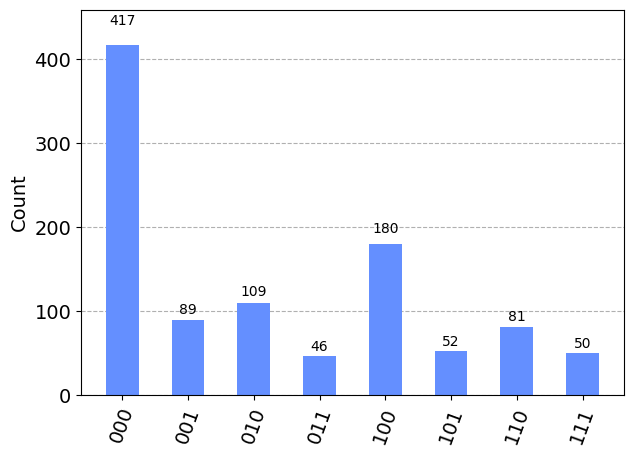

In [26]:
from qiskit.tools.visualization import plot_histogram

plot_histogram(noise_counts)

{'000': 417, '010': 109, '001': 89, '100': 180, '110': 81, '111': 50, '011': 46, '101': 52}
{'000': 1024}
{'000': 1441, '010': 109, '001': 89, '100': 180, '110': 81, '111': 50, '011': 46, '101': 52}


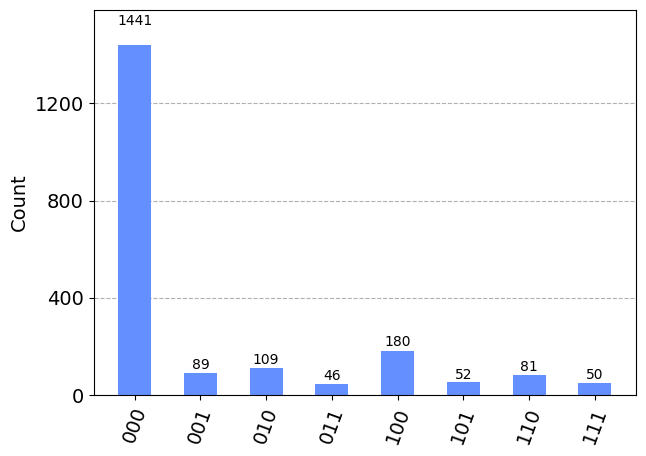

In [27]:
from qiskit.result import Counts
data = dict()
for key, value in counts.items():
    data[key] = data.get(key, 0) + value

for key, value in noise_counts.items():
    data[key] = data.get(key, 0) + value
    
print(noise_counts)
print(counts)
print(data)
plot_histogram(Counts(data))

## Learn about Pauli noise

add two clifford circuit

In [28]:
from numpy.random import Generator, default_rng
# from qiskit.quantum_info import Clifford, random_clifford
from typing import Optional, Union, Tuple, Sequence

def add_random_one_layer_clifford_2_qubit_gate(circ: QuantumCircuit, num_qubits: int, size: int, rng: Optional[Union[int, Generator]] = None):
    if rng is None:
        rng = default_rng()
    elif isinstance(rng, int):
        rng = default_rng(rng)
    # have some speed than random_clifford.
    
    samples = rng.integers(CliffordUtils.NUM_CLIFFORD_2_QUBIT, size=size)
    
    list_circuit = [CliffordUtils.clifford_2_qubit_circuit(i).to_instruction() for i in samples]
    
    for i in range(size):
        circ.append(list_circuit[i], [i*2,i*2+1])
    circ.barrier()
    return circ

In [29]:
def random_clifford_circuit(circ: QuantumCircuit, num_qubits: int, rep_m: int, num_qubit_twirl: int=1):
    # clifford_circuit 1 or clifford_circuit 2
    if num_qubit_twirl == 1:
        for _ in range(rep_m):
            # random clifford 1 gate on each qubit
            circ = add_random_one_layer_clifford_gate(circ, num_qubits, num_qubits)
    elif num_qubit_twirl == 2:
        for _ in range(rep_m):
            # random clifford 2 gate on two qubit pair
            circ = add_random_one_layer_clifford_2_qubit_gate(circ,num_qubits, num_qubits//2)
    else:
        raise("no support num_qubit_twirl than 2")
    return circ

In [30]:
from qiskit.quantum_info import Clifford
from qiskit import transpile

num_qubits = 3
m = 2
num_qubit_twirl = 1

qr_1 = QuantumRegister(num_qubits, 'q')
circ_1 = QuantumCircuit(qr_1)

qr_2 = QuantumRegister(num_qubits, 'q')
circ_2 = QuantumCircuit(qr_2)

circ_1 = random_clifford_circuit(circ_1, num_qubits, m, 1)
circ_2 = random_clifford_circuit(circ_2, num_qubits, m, 2)

# circ_1.draw(output="mpl", style="iqp")
# circ_2.draw(output="mpl", style="iqp")

In [31]:
inverse_circ1 = Clifford(circ_1.inverse()).to_circuit()
circ_1_compose = circ_1.compose(inverse_circ1)
# circ_1_compose.draw(output="mpl", style="iqp")

# Apply inverse
inverse_circ2 = Clifford(circ_2.inverse())
circ_2_compose = circ_2.compose(inverse_circ2)
# circ_2_compose.draw(output="mpl", style="iqp")


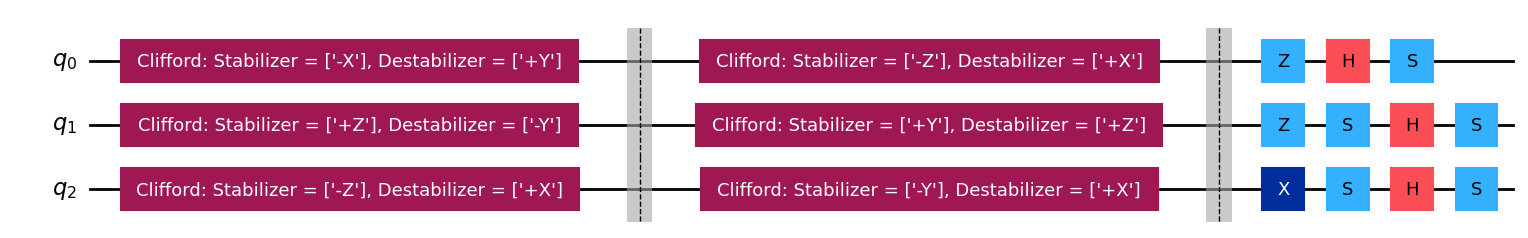

In [32]:
circ_1_compose.draw(output="mpl", style="iqp")

In [33]:
circ_1_compose.decompose(sim).draw()

┌──────────────────────────────────────────────────────┐ ░ »
q_0: ┤ Clifford: Stabilizer = ['-X'], Destabilizer = ['+Y'] ├─░─»
     ├──────────────────────────────────────────────────────┤ ░ »
q_1: ┤ Clifford: Stabilizer = ['+Z'], Destabilizer = ['-Y'] ├─░─»
     ├──────────────────────────────────────────────────────┤ ░ »
q_2: ┤ Clifford: Stabilizer = ['-Z'], Destabilizer = ['+X'] ├─░─»
     └──────────────────────────────────────────────────────┘ ░ »
«     ┌──────────────────────────────────────────────────────┐ ░ ┌───┐┌───┐»
«q_0: ┤ Clifford: Stabilizer = ['-Z'], Destabilizer = ['+X'] ├─░─┤ Z ├┤ H ├»
«     ├──────────────────────────────────────────────────────┤ ░ ├───┤├───┤»
«q_1: ┤ Clifford: Stabilizer = ['+Y'], Destabilizer = ['+Z'] ├─░─┤ Z ├┤ S ├»
«     ├──────────────────────────────────────────────────────┤ ░ ├───┤├───┤»
«q_2: ┤ Clifford: Stabilizer = ['-Y'], Destabilizer = ['+X'] ├─░─┤ X ├┤ S ├»
«     └──────────────────────────────────────────────────────┘ ░ └───┘└───┘»
«     ┌───┐     
«q_0: ┤ S ├─────
«     ├───┤┌───┐
«q_1: ┤ H ├┤ S ├
«     ├───┤├───┤
«q_2: ┤ H ├┤ S ├
«     └───┘└───┘

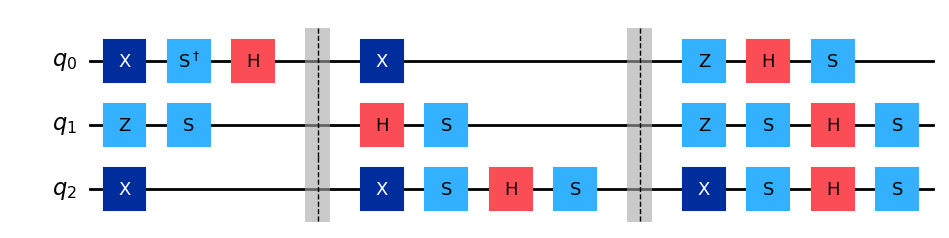

In [34]:
from qiskit_experiments.library.randomized_benchmarking.clifford_utils import _transpile_clifford_circuit
_transpile_clifford_circuit(circ_1_compose, tuple(range(3))).draw(output="mpl", style="iqp")

In [35]:
# def transpiled_circuits(self) -> List[QuantumCircuit]:
#     """Return a list of experiment circuits, transpiled."""
#     has_custom_transpile_option = (
#         not set(vars(self.transpile_options)).issubset({"basis_gates", "optimization_level"})
#         or self.transpile_options.get("optimization_level", 1) != 1
#     )
#     has_no_undirected_2q_basis = self._get_basis_gates() is None
#     if self.num_qubits > 2 or has_custom_transpile_option or has_no_undirected_2q_basis:
#         transpiled = super()._transpiled_circuits()
#     else:
#         transpiled = [
#             _transpile_clifford_circuit(circ, physical_qubits=self.physical_qubits)
#             for circ in self.circuits()
#         ]
#         # Set custom calibrations provided in backend
#         if isinstance(self.backend, BackendV2):
#             qargs_patterns = [self.physical_qubits]  # for self.num_qubits == 1
#             if self.num_qubits == 2:
#                 qargs_patterns = [
#                     (self.physical_qubits[0],),
#                     (self.physical_qubits[1],),
#                     self.physical_qubits,
#                     (self.physical_qubits[1], self.physical_qubits[0]),
#                 ]

#             instructions = []  # (op_name, qargs) for each element where qargs means qubit tuple
#             for qargs in qargs_patterns:
#                 for op_name in self.backend.target.operation_names_for_qargs(qargs):
#                     instructions.append((op_name, qargs))

#             common_calibrations = defaultdict(dict)
#             for op_name, qargs in instructions:
#                 inst_prop = self.backend.target[op_name].get(qargs, None)
#                 if inst_prop is None:
#                     continue
#                 try:
#                     schedule = inst_prop.calibration
#                 except AttributeError:
#                     # TODO remove after qiskit-terra/#9681 is in stable release.
#                     schedule = None
#                 if schedule is None:
#                     continue
#                 publisher = schedule.metadata.get("publisher", CalibrationPublisher.QISKIT)
#                 if publisher != CalibrationPublisher.BACKEND_PROVIDER:
#                     common_calibrations[op_name][(qargs, tuple())] = schedule

#             for circ in transpiled:
#                 # This logic is inefficient in terms of payload size and backend compilation
#                 # because this binds every custom pulse to a circuit regardless of
#                 # its existence. It works but redundant calibration must be removed -- NK.
#                 circ.calibrations = common_calibrations

#     if self.analysis.options.get("gate_error_ratio", None) is None:
#         # Gate errors are not computed, then counting ops is not necessary.
#         return transpiled

#     # Compute average basis gate numbers per Clifford operation
#     # This is probably main source of performance regression.
#     # This should be integrated into transpile pass in future.
#     qubit_indices = {bit: index for index, bit in enumerate(transpiled[0].qubits)}
#     for circ in transpiled:
#         count_ops_result = defaultdict(int)
#         # This is physical circuits, i.e. qargs is physical index
#         for inst, qargs, _ in circ.data:
#             if inst.name in ("measure", "reset", "delay", "barrier", "snapshot"):
#                 continue
#             qinds = [qubit_indices[q] for q in qargs]
#             if not set(self.physical_qubits).issuperset(qinds):
#                 continue
#             # Not aware of multi-qubit gate direction
#             formatted_key = tuple(sorted(qinds)), inst.name
#             count_ops_result[formatted_key] += 1
#         circ.metadata["count_ops"] = tuple(count_ops_result.items())

#     return transpiled

In [36]:
from typing import Optional, Union, Tuple, Sequence, List
from qiskit.result import Counts
from qiskit_experiments.library.randomized_benchmarking.clifford_utils import _transpile_clifford_circuit


def random_pauli_benchmarking(num_qubits: int, rep_m_list: List[int], num_1_qubit_twirl: int, num_2_qubit_twirl: int, shots: int, sim):
    """ This function is use to learning about pauli noise.
        .num_qubits: For each circuit, qubit's number.
        .rep_m_list: the test m list.
        .num_1_qubit_twirl:  For each m, the one clifford circuit by sample.
        .num_2_qubit_twirl:  For each m, the two clifford circuit by sample.
        .shots: For each circuit, repeat run circuit number.
        .sim: simulator for run circuit.
    """
    # For each m
    statistics_counts_list = []
    circuit_list = []
    result_list = []
    for m in rep_m_list:
        circuit_m_list = []
        result_m_list = []
        # counts_m_list = []
        counts_m_dict = dict()
        for job_id in range(num_1_qubit_twirl + num_2_qubit_twirl):
            # initial circuit
            qr = QuantumRegister(num_qubits, 'q')
            circ = QuantumCircuit(qr)
            if job_id < num_1_qubit_twirl:
                circ = random_clifford_circuit(circ, num_qubits, m, 1)
            elif (job_id >= num_1_qubit_twirl) and (job_id < num_1_qubit_twirl+num_2_qubit_twirl):
                circ = random_clifford_circuit(circ, num_qubits, m, 2)
            
            # Apply inverse
            inverse_circ = Clifford(circ.inverse()).to_circuit()
            # compose circuit
            circ_compose = circ.compose(inverse_circ)
            
            
            # transpile
            # try:
            # circ_compose.decompose()
            transpile_qc = transpile(circ_compose, sim, optimization_level = 0)
            # transpile_qc = _transpile_clifford_circuit(circ_compose, tuple(range(num_qubits)))
            # except:
                # print(f"transpile error, circuit is {circ}, job_id is {job_id}, m is {m}")
            
            
            # measurement
            transpile_qc.measure_all()
            
            # run in a simulator and get result 
            result = sim.run(transpile_qc, shots = shots).result()
            counts = result.get_counts()
            
            # append result
            circuit_m_list.append(transpile_qc)
            result_m_list.append(result)
            # counts_m_list.append(counts)
            
            # gather the counts about a kind of m
            for key, value in counts.items():
                counts_m_dict[key] = counts_m_dict.get(key, 0) + value
        print(f"now is running m = {m} experement")
        
        # use int to expect the key
        qiskit_counts = Counts(counts_m_dict)
        int_outcomes = qiskit_counts.int_outcomes()
        
        statistics_counts_list.append(int_outcomes)
        circuit_list.append(circuit_m_list)
        result_list.append(result_m_list)
    
    # get the Probability distributions list
    
    return circuit_list, result_list, statistics_counts_list

In [37]:
# noise model
# Example error probabilities
p_reset = 0.03
p_meas = 0.01

p_gate_x = 0.001
p_gate_y = 0.000
p_gate_z = 0.0000

# p_two_gate = 0.1
# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])

error_gate2 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])
error_two_gate = error_gate1.tensor(error_gate1)

# Add errors to noise model
pauli_noise_model= NoiseModel()
pauli_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
pauli_noise_model.add_all_qubit_quantum_error(error_meas, "measure")
pauli_noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
pauli_noise_model.add_all_qubit_quantum_error(error_two_gate, ["cx"])
sim_noise = AerSimulator(noise_model = pauli_noise_model)

idea_sim = AerSimulator()
# method="stabilizer"

In [38]:
sim_noise._basis_gates

<bound method AerSimulator._basis_gates of AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['cx', 'measure', 'u3', 'u1', 'u2', 'reset']>)>

In [39]:
# m = [0,1,2,3,4,6,8]
# list_m = np.array([1,2,3,4,6,8])
# depths = [d for d in m for _ in range(num_sequences_per_depth)]
list_m = [1,2,3,4,5,6,7,8,9,10]

list_m = range(1,15)
num_samples = 100
# only consider single qubit twirl
num_1_qubit_twirl = num_samples
num_2_qubit_twirl = int(num_samples - num_1_qubit_twirl)
num_qubits = 2
shots = 1024
seed = 1010

circuit_list, result_list, statistics_counts_list = random_pauli_benchmarking(num_qubits=num_qubits, rep_m_list = list_m, 
                                                                              num_1_qubit_twirl=num_1_qubit_twirl, num_2_qubit_twirl=num_2_qubit_twirl,
                                                                              shots = shots, sim = sim_noise)

now is running m = 1 experement
now is running m = 2 experement
now is running m = 3 experement
now is running m = 4 experement
now is running m = 5 experement
now is running m = 6 experement
now is running m = 7 experement
now is running m = 8 experement
now is running m = 9 experement
now is running m = 10 experement
now is running m = 11 experement
now is running m = 12 experement
now is running m = 13 experement
now is running m = 14 experement


快速 Walsh Hadamard 变换函数

99747


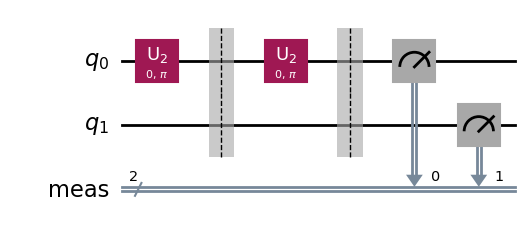

In [40]:
print(statistics_counts_list[0].get(0))
circuit_list[0][0].draw(output="mpl", style="iqp")

97158


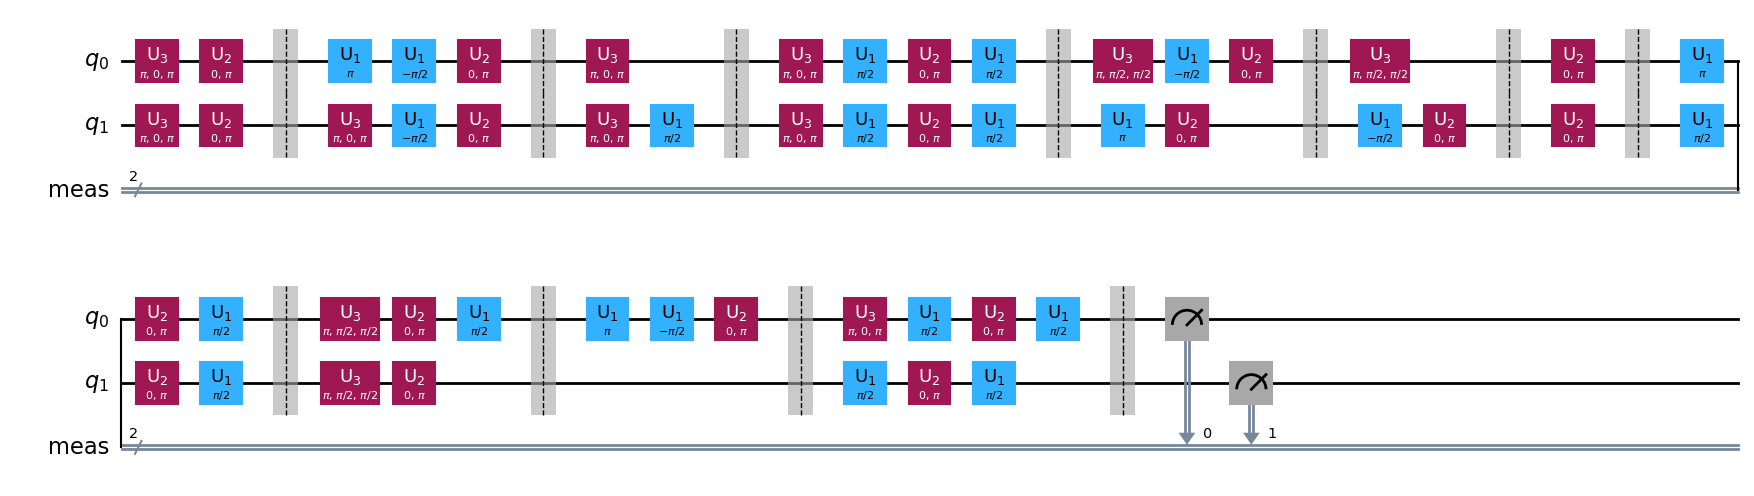

In [41]:
print(statistics_counts_list[9].get(0))
circuit_list[9][0].draw(output="mpl", style="iqp")

In [42]:
# max(statistics_counts_list[0].keys()) == 2**num_qubits-1

def iwfht(x):
    """逆快速 Walsh Hadamard 变换函数"""
    n = len(x)
    h = 1
    while h < n:
        for i in range(0, n, h * 2):
            for j in range(i, i + h):
                x[j], x[j + h] = x[j] + x[j + h], x[j] - x[j + h]
        h *= 2
    return x

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 指数函数模型，用于拟合
def exponential_model(x, a, b):
    return a * (b ** x)

def fit_iws_lambda(statistics_counts_list: List[dict], num_qubits: int, num_samples: int, shots: int):
    ws_results = []
    for m_id in range(len(list_m)):
        m = list_m[m_id]
        list_pro = [statistics_counts_list[m_id].get(i, 0) for i in range(2**num_qubits)]
        # print(list_pro)
        # print(sum(list_pro))
        num_exper = int(num_samples*shots)
        ws_result = np.array(iwfht(list_pro))/num_exper
        # print(ws_result)
        ws_results.append(ws_result)
    ws_results = np.array(ws_results)

    lambda_list = []
    for i in range(2**num_qubits):
        # print(ws_results[:,i])
        x_data = np.array(list_m)
        y_data = ws_results[:,i]
        # 拟合数据
        popt, pcov = curve_fit(exponential_model, x_data, y_data, p0=[1.0, 1.0])
        # print(f"拟合参数: A = {popt[0]}, lambda = {popt[1]}")
        lambda_list.append(popt[1])

    print(lambda_list)
    return lambda_list

lambda_list = fit_iws_lambda(statistics_counts_list, num_qubits, num_samples, shots)

from sympy import fwht
 
# hwht
transform = fwht(lambda_list)
print ("Transform  : ", transform)

[1.0, 0.9970210452506398, 0.9970045691728328, 0.9940681505532057]
Transform  :  [3.98809376497668, 0.00591537336898718, 0.00594832552460134, 4.25361297331506e-5]


In [44]:

import numpy as np
 
def list_to_probability(lst):
    # 将实数列表转换为概率值
    probabilities = np.array(lst, dtype=np.float64)
    # make sure is >=0
    if np.min(probabilities) < 0:
        probabilities = probabilities - np.min(probabilities)
        
    # 归一化概率值
    sum_probabilities = np.sum(probabilities)
    
    if sum_probabilities != 0:
        probabilities = probabilities / sum_probabilities
    # probabilities = np.round(probabilities, 5)
    
    return probabilities

# 二进制表示
def to_binary_string(number, length: int):
    return format(number, '0' + str(length) + 'b')

# 保留6为小数 
probabilities = list_to_probability(transform)
# print(np.array(probabilities*100000, dtype=np.int32))

probabilities = np.array(probabilities*100000, dtype=np.int32) / sum(np.array(probabilities*100000, dtype=np.int32))
print(probabilities)

# 整数处理
qubit_error_rates = []
for index in range(num_qubits-1, -1,-1):
    qubit_error_rate = 0
    # for qubit
    for i in range(2**num_qubits):
        # for seq
        if to_binary_string(i, num_qubits)[index] == "1":
            qubit_error_rate += probabilities[i]
            # print(index,i, probabilities[i])
    qubit_error_rates.append(qubit_error_rate)

print(qubit_error_rates)

[9.97039941e-01 1.47002940e-03 1.48002960e-03 1.00002000e-05]
[0.001480029600592012, 0.001490029800596012]


In [45]:
print ("特征值: ", lambda_list)
print("概率: ",probabilities)
print("边缘概率: ", qubit_error_rates)

特征值:  [1.0, 0.9970210452506398, 0.9970045691728328, 0.9940681505532057]
概率:  [9.97039941e-01 1.47002940e-03 1.48002960e-03 1.00002000e-05]
边缘概率:  [0.001480029600592012, 0.001490029800596012]


In [46]:
# noise model
# Example error probabilities
p_reset = 0.03
p_meas = 0.01

p_gate_x = 0.001
p_gate_y = 0.000
p_gate_z = 0.0000

# p_two_gate = 0.1
# QuantumError objects
# error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
# error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])

# error_gate2 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])
# error_two_gate = error_gate1.tensor(error_gate1)

# Add errors to noise model
pauli_noise_model= NoiseModel()
# pauli_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
# pauli_noise_model.add_all_qubit_quantum_error(error_meas, "measure")
pauli_noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
# pauli_noise_model.add_all_qubit_quantum_error(error_two_gate, ["cx"])
sim_noise_not_spam = AerSimulator(noise_model = pauli_noise_model)

# idea_sim = AerSimulator()
# method="stabilizer"

In [47]:
count_0 =0
count_1 = 0

for i in range(1000):
    qr = QuantumRegister(1, 'q')
    circ = QuantumCircuit(qr)

    circ = random_clifford_circuit(circ, 1, 1, 1)


    # Apply inverse
    inverse_circ = Clifford(circ.inverse()).to_circuit()
    # compose circuit
    circ_compose = circ.compose(inverse_circ)
                
                
    # transpile
    # try:
    # circ_compose.decompose()
    transpile_qc = transpile(circ_compose, sim_noise_not_spam, optimization_level = 0)
    # transpile_qc = _transpile_clifford_circuit(circ_compose, tuple(range(num_qubits)))
    # except:
    # print(f"transpile error, circuit is {circ}, job_id is {job_id}, m is {m}")
                
    # measurement
    transpile_qc.measure_all()

    # run in a simulator and get result 
    result = sim_noise_not_spam.run(transpile_qc, shots = 1024).result()
    counts = result.get_counts()
    # print(counts)
    count_0 += counts['0']
    count_1 += counts.get('1',0)

In [48]:
# count_1/(count_0+count_1)
1-np.sqrt((1-count_1/(count_0+count_1)))

0.0015412267524512746

In [49]:
from typing import Optional, Union, Tuple, Sequence, List
from qiskit.result import Counts
from qiskit_experiments.library.randomized_benchmarking.clifford_utils import _transpile_clifford_circuit

count_00 =0
count_01 = 0
count_10 = 0
count_11 = 0

for i in range(100):
    qr = QuantumRegister(2, 'q')
    circ = QuantumCircuit(qr)

    circ = random_clifford_circuit(circ, 2, 1, 1)


    # Apply inverse
    inverse_circ = Clifford(circ.inverse()).to_circuit()
    # compose circuit
    circ_compose = circ.compose(inverse_circ)
                
                
    # transpile
    # try:
    # circ_compose.decompose()
    transpile_qc = transpile(circ_compose, sim_noise_not_spam, optimization_level = 0)
    # transpile_qc = _transpile_clifford_circuit(circ_compose, tuple(range(num_qubits)))
    # except:
    # print(f"transpile error, circuit is {circ}, job_id is {job_id}, m is {m}")
                
    # measurement
    transpile_qc.measure_all()

    # run in a simulator and get result 
    result = sim_noise_not_spam.run(transpile_qc, shots = 1024).result()
    counts = result.get_counts()
    # print(counts)
    count_00 += counts['00']
    count_01 += counts.get('01',0)
    count_10 += counts.get('10',0)
    count_11 += counts.get('11',0)

In [50]:
count_00/ (count_00+count_01+count_10+count_11)

0.99310546875

In [51]:
count_01/ (count_00+count_01+count_10+count_11)
1-np.sqrt((1-count_01/ (count_00+count_01+count_10+count_11)))

0.0017153383803796274

In [52]:
count_10/ (count_00+count_01+count_10+count_11)

0.00345703125

In [53]:
count_11/(count_00+count_01+count_10+count_11)

9.765625e-06

## Show the result is the error rate per Clifford and SPAM-free

In [56]:
def pauli_noise_model(p_x, p_y, p_z, spam:bool):
    p_reset = 0.03
    p_meas = 0.01

    p_gate_x = p_x
    p_gate_y = p_y
    p_gate_z = p_z

    # p_two_gate = 0.1
    # QuantumError objects
    # error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    # error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])

    # error_gate2 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])
    # error_two_gate = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    pauli_noise_model= NoiseModel()
    if spam:
        pauli_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
        pauli_noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    pauli_noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    # pauli_noise_model.add_all_qubit_quantum_error(error_two_gate, ["cx"])
    sim_noise_not_spam = AerSimulator(noise_model = pauli_noise_model)
    
    return sim_noise_not_spam

for pauli_x in range(1,10):
    print(f"No.{pauli_x}--------------")
    bit_flip_noise_model = pauli_noise_model(pauli_x*0.001,0,0,False)
    
    # pauli learning
    list_m = [1,2,3,4,5,6,7,8,9,10]
    num_samples = 100
    # only consider single qubit twirl
    num_1_qubit_twirl = num_samples
    num_2_qubit_twirl = int(num_samples - num_1_qubit_twirl)
    num_qubits = 2
    shots = 1024
    seed = 1010

    circuit_list, result_list, statistics_counts_list = random_pauli_benchmarking(num_qubits=num_qubits, rep_m_list = list_m, 
                                                                              num_1_qubit_twirl=num_1_qubit_twirl, num_2_qubit_twirl=num_2_qubit_twirl,
                                                                              shots = shots, sim = bit_flip_noise_model)
    lambda_list = fit_iws_lambda(statistics_counts_list, num_qubits, num_samples, shots)
    transform = fwht(lambda_list)
    probabilities = list_to_probability(transform)
    probabilities = np.array(probabilities*100000, dtype=np.int32) / sum(np.array(probabilities*100000, dtype=np.int32))

    # 整数处理
    qubit_error_rates = []
    for index in range(num_qubits-1, -1,-1):
        qubit_error_rate = 0
        # for qubit
        for i in range(2**num_qubits):
            # for seq
            if to_binary_string(i, num_qubits)[index] == "1":
                qubit_error_rate += probabilities[i]
                # print(index,i, probabilities[i])
        qubit_error_rates.append(qubit_error_rate)
    
    #idea
    count_0 =0
    count_1 = 0
    for i in range(100):
        qr = QuantumRegister(1, 'q')
        circ = QuantumCircuit(qr)

        circ = random_clifford_circuit(circ, 1, 1, 1)


        # Apply inverse
        inverse_circ = Clifford(circ.inverse()).to_circuit()
        # compose circuit
        circ_compose = circ.compose(inverse_circ)
                    
                    
        # transpile
        # try:
        # circ_compose.decompose()
        transpile_qc = transpile(circ_compose, bit_flip_noise_model, optimization_level = 0)
        # transpile_qc = _transpile_clifford_circuit(circ_compose, tuple(range(num_qubits)))
        # except:
        # print(f"transpile error, circuit is {circ}, job_id is {job_id}, m is {m}")
                    
        # measurement
        transpile_qc.measure_all()

        # run in a simulator and get result 
        result = bit_flip_noise_model.run(transpile_qc, shots = 1024).result()
        counts = result.get_counts()
        # print(counts)
        count_0 += counts['0']
        count_1 += counts.get('1',0)
    
    print(f"pauli noise learning method's result: {qubit_error_rates}, test error rate per clifford: {1-np.sqrt((1-count_1/(count_0+count_1)))}")
    

No.1--------------
now is running m = 1 experement
now is running m = 2 experement
now is running m = 3 experement
now is running m = 4 experement
now is running m = 5 experement
now is running m = 6 experement
now is running m = 7 experement
now is running m = 8 experement
now is running m = 9 experement
now is running m = 10 experement
[1.0, 0.9968717876170096, 0.9970545548230171, 0.9939197796772208]
pauli noise learning method's result: [0.0015600312006240125, 0.0014700294005880118], test error rate per clifford: 0.0017055560231741262
No.2--------------
now is running m = 1 experement
now is running m = 2 experement
now is running m = 3 experement
now is running m = 4 experement
now is running m = 5 experement
now is running m = 6 experement
now is running m = 7 experement
now is running m = 8 experement
now is running m = 9 experement
now is running m = 10 experement
[1.0, 0.9940376048378564, 0.9938894332156847, 0.9879801444110075]
pauli noise learning method's result: [0.002970059

If not consider the SPAM error, the result is like:

No.1--------------

pauli noise learning method's result: [0.0015600312006240125, 0.0014700294005880118], test error rate per clifford: 0.0017055560231741262

No.2--------------

pauli noise learning method's result: [0.0029700594011880235, 0.0030500610012200243], test error rate per clifford: 0.00337973474095965

No.3--------------

pauli noise learning method's result: [0.0044200884017680355, 0.004500090001800036], test error rate per clifford: 0.004438561350933012

No.4--------------

pauli noise learning method's result: [0.005830116602332046, 0.0058801176023520465], test error rate per clifford: 0.006323705563527127

No.5--------------

pauli noise learning method's result: [0.0073401468029360584, 0.007400148002960059], test error rate per clifford: 0.007971223325653698

No.6--------------

pauli noise learning method's result: [0.009080090800908009, 0.009030090300903008], test error rate per clifford: 0.009168002699246669

No.7--------------

pauli noise learning method's result: [0.01034010340103401, 0.01037010370103701], test error rate per clifford: 0.011570848517709842

No.8--------------

pauli noise learning method's result: [0.012040361210836325, 0.011960358810764323], test error rate per clifford: 0.013068795140715017

No.9--------------

pauli noise learning method's result: [0.013580407412222367, 0.013110393311799353], test error rate per clifford: 0.013860708051342319

This show that the result is likely same.

In [57]:
def pauli_noise_model(p_x, p_y, p_z, spam:bool):
    p_reset = 0.03
    p_meas = 0.01

    p_gate_x = p_x
    p_gate_y = p_y
    p_gate_z = p_z

    # p_two_gate = 0.1
    # QuantumError objects
    # error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    # error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])

    # error_gate2 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])
    # error_two_gate = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    pauli_noise_model= NoiseModel()
    if spam:
        pauli_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
        pauli_noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    pauli_noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    # pauli_noise_model.add_all_qubit_quantum_error(error_two_gate, ["cx"])
    sim_noise_not_spam = AerSimulator(noise_model = pauli_noise_model)
    
    return sim_noise_not_spam


bit_flip_noise_model = pauli_noise_model(1*0.001,0,0,True)

# pauli learning
list_m = [1,2,3,4,5,6,7,8,9,10]
num_samples = 100
# only consider single qubit twirl
num_1_qubit_twirl = num_samples
num_2_qubit_twirl = int(num_samples - num_1_qubit_twirl)
num_qubits = 2
shots = 1024
seed = 1010

circuit_list, result_list, statistics_counts_list = random_pauli_benchmarking(num_qubits=num_qubits, rep_m_list = list_m, 
                                                                            num_1_qubit_twirl=num_1_qubit_twirl, num_2_qubit_twirl=num_2_qubit_twirl,
                                                                            shots = shots, sim = bit_flip_noise_model)
lambda_list = fit_iws_lambda(statistics_counts_list, num_qubits, num_samples, shots)
transform = fwht(lambda_list)
probabilities = list_to_probability(transform)
probabilities = np.array(probabilities*100000, dtype=np.int32) / sum(np.array(probabilities*100000, dtype=np.int32))

# 整数处理
qubit_error_rates = []
for index in range(num_qubits-1, -1,-1):
    qubit_error_rate = 0
    # for qubit
    for i in range(2**num_qubits):
        # for seq
        if to_binary_string(i, num_qubits)[index] == "1":
            qubit_error_rate += probabilities[i]
            # print(index,i, probabilities[i])
    qubit_error_rates.append(qubit_error_rate)

#idea
count_0 =0
count_1 = 0
for i in range(100):
    qr = QuantumRegister(1, 'q')
    circ = QuantumCircuit(qr)

    circ = random_clifford_circuit(circ, 1, 1, 1)


    # Apply inverse
    inverse_circ = Clifford(circ.inverse()).to_circuit()
    # compose circuit
    circ_compose = circ.compose(inverse_circ)
                
                
    # transpile
    # try:
    # circ_compose.decompose()
    transpile_qc = transpile(circ_compose, bit_flip_noise_model, optimization_level = 0)
    # transpile_qc = _transpile_clifford_circuit(circ_compose, tuple(range(num_qubits)))
    # except:
    # print(f"transpile error, circuit is {circ}, job_id is {job_id}, m is {m}")
                
    # measurement
    transpile_qc.measure_all()

    # run in a simulator and get result 
    result = bit_flip_noise_model.run(transpile_qc, shots = 1024).result()
    counts = result.get_counts()
    # print(counts)
    count_0 += counts['0']
    count_1 += counts.get('1',0)

print(f"pauli noise learning method's result: {qubit_error_rates}, test error rate per clifford: {1-np.sqrt((1-count_1/(count_0+count_1)))}")
    

now is running m = 1 experement
now is running m = 2 experement
now is running m = 3 experement
now is running m = 4 experement
now is running m = 5 experement
now is running m = 6 experement
now is running m = 7 experement
now is running m = 8 experement
now is running m = 9 experement
now is running m = 10 experement
[1.0, 0.9970564208400428, 0.9969567630931048, 0.9940417109379137]
pauli noise learning method's result: [0.0014600292005840117, 0.001510030200604012], test error rate per clifford: 0.006844714118179773


If consider the SPAM error, the result of nose learning is not be a lot of difference, but the test error rate will be impacted by the SPAM error.

No.1--------------(no SPAM)
pauli noise learning method's result: [0.0015600312006240125, 0.0014700294005880118], test error rate per clifford: 0.0017055560231741262

No.1--------------(have SPAM)
pauli noise learning method's result: [0.0014600292005840117, 0.001510030200604012], test error rate per clifford: 0.006844714118179773

next we consider not only bit flip error.

In [58]:
def pauli_noise_model(p_x, p_y, p_z, spam:bool):
    p_reset = 0.03
    p_meas = 0.01

    p_gate_x = p_x
    p_gate_y = p_y
    p_gate_z = p_z

    # p_two_gate = 0.1
    # QuantumError objects
    # error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    # error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])

    # error_gate2 = pauli_error([('X',p_gate_x), ('Y',p_gate_y), ('Z',p_gate_z), ('I', 1 - (p_gate_x+p_gate_y+p_gate_z))])
    # error_two_gate = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    pauli_noise_model= NoiseModel()
    if spam:
        pauli_noise_model.add_all_qubit_quantum_error(error_reset, "reset")
        pauli_noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    pauli_noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    # pauli_noise_model.add_all_qubit_quantum_error(error_two_gate, ["cx"])
    sim_noise_not_spam = AerSimulator(noise_model = pauli_noise_model)
    
    return sim_noise_not_spam

for pauli_x in range(1,10):
    print(f"No.{pauli_x}--------------")
    bit_flip_noise_model = pauli_noise_model(pauli_x*0.001,pauli_x*0.001,pauli_x*0.001,False)
    
    # pauli learning
    list_m = [1,2,3,4,5,6,7,8,9,10]
    num_samples = 100
    # only consider single qubit twirl
    num_1_qubit_twirl = num_samples
    num_2_qubit_twirl = int(num_samples - num_1_qubit_twirl)
    num_qubits = 2
    shots = 1024
    seed = 1010

    circuit_list, result_list, statistics_counts_list = random_pauli_benchmarking(num_qubits=num_qubits, rep_m_list = list_m, 
                                                                              num_1_qubit_twirl=num_1_qubit_twirl, num_2_qubit_twirl=num_2_qubit_twirl,
                                                                              shots = shots, sim = bit_flip_noise_model)
    lambda_list = fit_iws_lambda(statistics_counts_list, num_qubits, num_samples, shots)
    transform = fwht(lambda_list)
    probabilities = list_to_probability(transform)
    probabilities = np.array(probabilities*100000, dtype=np.int32) / sum(np.array(probabilities*100000, dtype=np.int32))

    # 整数处理
    qubit_error_rates = []
    for index in range(num_qubits-1, -1,-1):
        qubit_error_rate = 0
        # for qubit
        for i in range(2**num_qubits):
            # for seq
            if to_binary_string(i, num_qubits)[index] == "1":
                qubit_error_rate += probabilities[i]
                # print(index,i, probabilities[i])
        qubit_error_rates.append(qubit_error_rate)
    
    #idea
    count_0 =0
    count_1 = 0
    for i in range(100):
        qr = QuantumRegister(1, 'q')
        circ = QuantumCircuit(qr)

        circ = random_clifford_circuit(circ, 1, 1, 1)


        # Apply inverse
        inverse_circ = Clifford(circ.inverse()).to_circuit()
        # compose circuit
        circ_compose = circ.compose(inverse_circ)
                    
                    
        # transpile
        # try:
        # circ_compose.decompose()
        transpile_qc = transpile(circ_compose, bit_flip_noise_model, optimization_level = 0)
        # transpile_qc = _transpile_clifford_circuit(circ_compose, tuple(range(num_qubits)))
        # except:
        # print(f"transpile error, circuit is {circ}, job_id is {job_id}, m is {m}")
                    
        # measurement
        transpile_qc.measure_all()

        # run in a simulator and get result 
        result = bit_flip_noise_model.run(transpile_qc, shots = 1024).result()
        counts = result.get_counts()
        # print(counts)
        count_0 += counts['0']
        count_1 += counts.get('1',0)
    
    print(f"pauli noise learning method's result: {qubit_error_rates}, test error rate per clifford: {1-np.sqrt((1-count_1/(count_0+count_1)))}")
    

No.1--------------
now is running m = 1 experement
now is running m = 2 experement
now is running m = 3 experement
now is running m = 4 experement
now is running m = 5 experement
now is running m = 6 experement
now is running m = 7 experement
now is running m = 8 experement
now is running m = 9 experement
now is running m = 10 experement
[1.0, 0.9908050237805032, 0.9910911245382781, 0.9820161930053847]
pauli noise learning method's result: [0.004590091801836037, 0.004450089001780036], test error rate per clifford: 0.004752504085039133
No.2--------------
now is running m = 1 experement
now is running m = 2 experement
now is running m = 3 experement
now is running m = 4 experement
now is running m = 5 experement
now is running m = 6 experement
now is running m = 7 experement
now is running m = 8 experement
now is running m = 9 experement
now is running m = 10 experement
[1.0, 0.9823832687620931, 0.9820479438497219, 0.9647137129176075]
pauli noise learning method's result: [0.008800176003

: 

No.1--------------

[1.0, 0.9908050237805032, 0.9910911245382781, 0.9820161930053847]

pauli noise learning method's result: [0.004590091801836037, 0.004450089001780036], test error rate per clifford: 0.004752504085039133

No.2--------------

[1.0, 0.9823832687620931, 0.9820479438497219, 0.9647137129176075]

pauli noise learning method's result: [0.00880017600352007, 0.008970179403588071], test error rate per clifford: 0.008084436872270895

No.3--------------

[1.0, 0.973154607162261, 0.9733456138224927, 0.9474406133900268]

pauli noise learning method's result: [0.013410268205364107, 0.013320266405328105], test error rate per clifford: 0.012856076856064491

No.4--------------

[1.0, 0.964259357675796, 0.9646950548007148, 0.9301574107112593]

pauli noise learning method's result: [0.017860357207144142, 0.01765035300706014], test error rate per clifford: 0.016389185513396187

No.5--------------

[1.0, 0.956125712182085, 0.9557909053348158, 0.9137510357652325]

pauli noise learning method's result: [0.02192065761972859, 0.022090662719881596], test error rate per clifford: 0.021670348885407642

No.6--------------

[1.0, 0.9495074822276961, 0.9467877427919211, 0.8985839181314031]

pauli noise learning method's result: [0.025240504810096202, 0.026600532010640214], test error rate per clifford: 0.024319147979217526

No.7--------------

[1.0, 0.9399593758686645, 0.9380163392911415, 0.8811779450717159]

pauli noise learning method's result: [0.03001060021200424, 0.030990619812396248], test error rate per clifford: 0.031885288950735946

No.8--------------

[1.0, 0.9290840027721433, 0.9297993583395655, 0.8638941509524729]

pauli noise learning method's result: [0.035450709014180286, 0.035090701814036285], test error rate per clifford: 0.034678445736862185

No.9--------------

[1.0, 0.9194573320905796, 0.9229579430286726, 0.8474432943613984]

pauli noise learning method's result: [0.040260805216104326, 0.03851077021540431], test error rate per clifford: 0.038799578651777744

New Noise model

In [ ]:
import numpy as np

from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

backend = AerSimulator.from_backend(FakePerth())

list_m = [1,2,3,4,5,6]
num_samples = 50
# only consider single qubit twirl
num_1_qubit_twirl = num_samples
num_2_qubit_twirl = int(num_samples - num_1_qubit_twirl)
num_qubits = backend.num_qubits
shots = 256
seed = 1010

circuit_list, result_list, statistics_counts_list = random_pauli_benchmarking(num_qubits=num_qubits, rep_m_list = list_m, 
                                                                              num_1_qubit_twirl=num_1_qubit_twirl, num_2_qubit_twirl=num_2_qubit_twirl,
                                                                              shots = shots, sim = backend)

now is running m = 1 experement
now is running m = 2 experement
now is running m = 3 experement
now is running m = 4 experement
now is running m = 5 experement
now is running m = 6 experement


11316


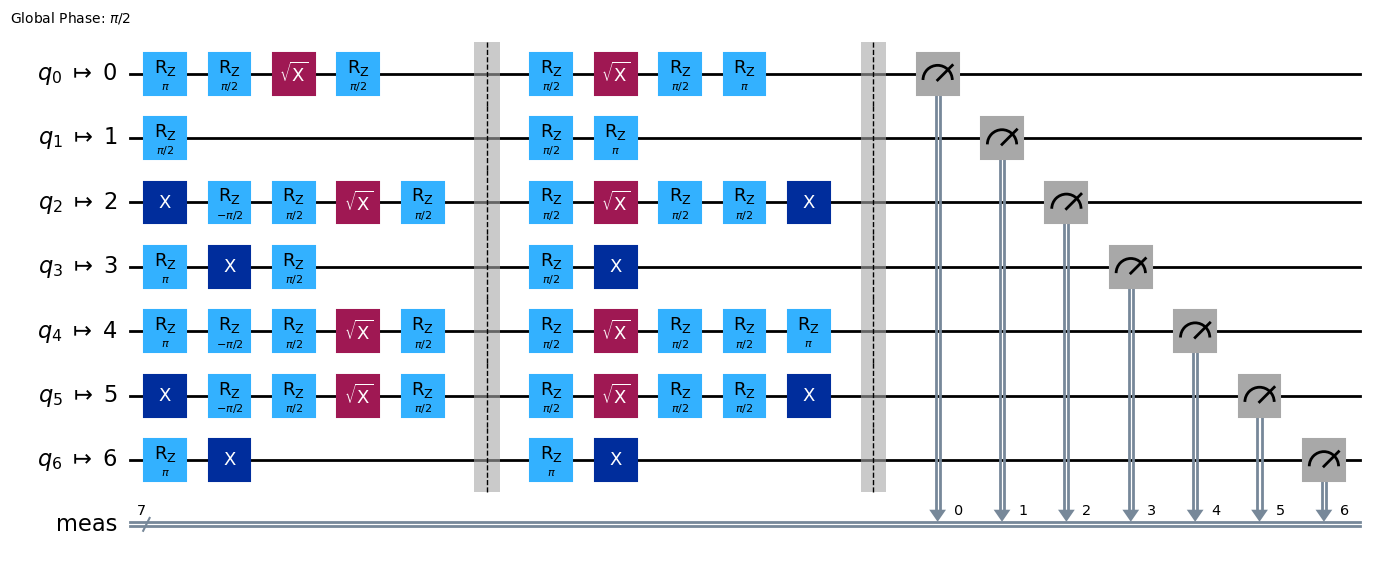

In [ ]:
print(statistics_counts_list[0].get(0))
circuit_list[0][0].draw(output="mpl", style="iqp")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 指数函数模型，用于拟合
def exponential_model(x, a, b):
    return a * (b ** x)

ws_results = []
for m_id in range(len(list_m)):
    m = list_m[m_id]
    list_pro = [statistics_counts_list[m_id].get(i, 0) for i in range(2**num_qubits)]
    # print(list_pro)
    # print(sum(list_pro))
    num_exper = int(num_samples*shots)
    ws_result = np.array(iwfht(list_pro))/num_exper
    # print(ws_result)
    ws_results.append(ws_result)
ws_results = np.array(ws_results)

lambda_list = []
for i in range(2**num_qubits):
    # print(ws_results[:,i])
    x_data = np.array(list_m)
    y_data = ws_results[:,i]
    # 拟合数据
    popt, pcov = curve_fit(exponential_model, x_data, y_data, p0=[1.0, 1.0])
    # print(f"拟合参数: A = {popt[0]}, lambda = {popt[1]}")
    lambda_list.append(popt[1])

print(lambda_list)

from sympy import fwht
 
# hwht
transform = fwht(lambda_list)
print ("Transform  : ", transform)

[1.0, 0.9995400298548882, 0.9995878725463543, 0.999391462466705, 0.9991401530155616, 0.9989015802640593, 0.9986422399283171, 0.9986835774056503, 0.9998989052529739, 0.9994590718115067, 0.9995187257204874, 0.9993540118155028, 0.9991339179317152, 0.9989297374105964, 0.9986719002716515, 0.9987600825422621, 0.9993517151866276, 0.99869683284345, 0.9990791444847124, 0.9986225831910557, 0.9983458849785021, 0.9979145075049091, 0.9979857005715563, 0.9977666753832799, 0.9994582854136559, 0.9988514478403472, 0.9992327551408887, 0.998835423847398, 0.9985573737764539, 0.9981897578816619, 0.9982489965698322, 0.9981057939610519, 0.9991137567458672, 0.9987248980828088, 0.998814489214831, 0.9987129903284816, 0.9981933710203553, 0.9981002980621613, 0.9978089816835158, 0.99802328523277, 0.9991639367503038, 0.9987474071028396, 0.9989087182261046, 0.998790279334686, 0.9983478637747147, 0.9982423430117727, 0.9980121497703193, 0.9982256104279174, 0.9982819187122756, 0.9975028582555132, 0.9981314722343102, 0.

In [ ]:

import numpy as np
 
def list_to_probability(lst):
    # 将实数列表转换为概率值
    probabilities = np.array(lst, dtype=np.float64)
    # make sure is >=0
    if np.min(probabilities) < 0:
        probabilities = probabilities - np.min(probabilities)
        
    # 归一化概率值
    sum_probabilities = np.sum(probabilities)
    
    if sum_probabilities != 0:
        probabilities = probabilities / sum_probabilities
    # probabilities = np.round(probabilities, 5)
    
    return probabilities

# 二进制表示
def to_binary_string(number, length: int):
    return format(number, '0' + str(length) + 'b')

# 保留6为小数 
probabilities = list_to_probability(transform)
# print(np.array(probabilities*100000, dtype=np.int32))

probabilities = np.array(probabilities*100000, dtype=np.int32) / sum(np.array(probabilities*100000, dtype=np.int32))
# print(probabilities)

# 整数处理
qubit_error_rates = []
for index in range(num_qubits-1, -1,-1):
    qubit_error_rate = 0
    # for qubit
    for i in range(2**num_qubits):
        # for seq
        if to_binary_string(i, num_qubits)[index] == "1":
            qubit_error_rate += probabilities[i]
            # print(index,i, probabilities[i])
    qubit_error_rates.append(qubit_error_rate)

    
print(qubit_error_rates)

[0.005383391536668104, 0.005333360016810594, 0.005543492400212138, 0.0052032780651810676, 0.005463441968440121, 0.005573511312126644, 0.005633549135955656]


average error rate is:

[0.005383391536668104, 0.005333360016810594, 0.005543492400212138, 0.0052032780651810676, 0.005463441968440121, 0.005573511312126644, 0.005633549135955656]
